In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# get inception model weights
#
# !wget --no-check-certificate https: // storage.googleapis.com / mledu-datasets / inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [11]:
from tensorflow.keras.optimizers import RMSprop

# flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# notice here how we lock the convolutional layers from the inception model and then append the additional layers "x" to it
model = Model(pre_trained_model.input, x)

model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [12]:
# get the cats_and_dogs_dataset

# !gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# train the model, callback to stop once both train and validation accuracy above 96%
from tensorflow.keras.callbacks import Callback


class StopModelCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print(logs)
        if logs.get('accuracy') >= 0.96 and logs.get("val_accuracy") >= 0.96:
            print("\nReached 98% accuracy... stopping training")
            self.model.stop_training = True


callbacks = StopModelCallback()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=50,
    callbacks=[callbacks]
)

Epoch 1/50
10/10 [==============================] - 23s 2s/step - loss: 4.9597 - accuracy: 0.6650 - val_loss: 1.5052 - val_accuracy: 0.7440
{'loss': 4.959711074829102, 'accuracy': 0.6650000214576721, 'val_loss': 1.5051541328430176, 'val_accuracy': 0.7440000176429749}
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: 1.2596 - accuracy: 0.8150 - val_loss: 0.6688 - val_accuracy: 0.8920
{'loss': 1.2595847845077515, 'accuracy': 0.8149999976158142, 'val_loss': 0.6687855124473572, 'val_accuracy': 0.8920000195503235}
Epoch 3/50
10/10 [==============================] - 15s 2s/step - loss: 0.7867 - accuracy: 0.8450 - val_loss: 0.4499 - val_accuracy: 0.9120
{'loss': 0.7866947054862976, 'accuracy': 0.8450000286102295, 'val_loss': 0.44989126920700073, 'val_accuracy': 0.9120000004768372}
Epoch 4/50
10/10 [==============================] - 15s 2s/step - loss: 0.9723 - accuracy: 0.8350 - val_loss: 2.2962 - val_accuracy: 0.7780
{'loss': 0.9722505807876587, 'accuracy': 0.8349999785

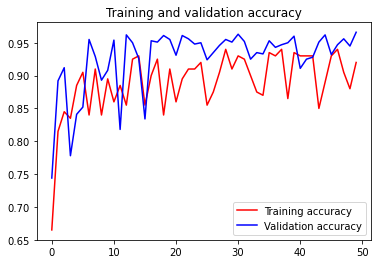

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()